In [50]:
# importing data manipulation libraries
import pandas as pd
import numpy as np
# from ydata_profiling import ProfileReport

# importing visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

# import ML tools 
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Embedding
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score

from datetime import datetime

# configure notebook for inline plotting
%matplotlib inline

# config pandas to display more than 20 columns
pd.set_option('display.max_columns',250)

# set grid style 
sns.set_style('darkgrid')

In [2]:
# load data from file
data = pd.read_csv('./data/aggredated_testing_data.csv', header=0)

# inspect the dataframe
data.head()

,id,homeID,awayID,home_name,away_name,date,season,status,homeGoalCount,awayGoalCount,totalGoalCount,team_a_cards_num,team_b_cards_num,odds_ft_1,odds_ft_x,odds_ft_2,home_ppg,away_ppg,team_a_xg_prematch,team_b_xg_prematch,total_xg_prematch,xG_home,xG_away,xGA_home,xGA_away,npxG_home,npxG_away,npxGA_home,npxGA_away,deep_home,deep_away,deep_allowed_home,deep_allowed_away,scored_home,scored_away,missed_home,missed_away,xpts_home,xpts_away,npxGD_home,npxGD_away,ppda.att_home,ppda.att_away,ppda.def_home,ppda.def_away,ppda_allowed.att_home,ppda_allowed.att_away,ppda_allowed.def_home,ppda_allowed.def_away
0,6688951,145,93,Burnley,Manchester City,2023-08-11,2023/2024,complete,0,3,3,2,0,11.00,6.30,1.28,0.36,2.00,0.0,0.0,0.0,0.311032,2.400740,2.400740,0.311032,0.311032,2.400740,2.400740,0.311032,4.0,9.0,9.0,4.0,0.0,3.0,3.0,0.0,0.1385,2.7761,-2.089708,2.089708,463.0,237.0,14.0,15.0,237.0,463.0,15.0,14.0
1,6688952,59,211,Arsenal,Nottingham Forest,2023-08-12,2023/2024,complete,2,1,3,2,2,1.25,6.25,9.50,2.36,0.73,0.0,0.0,0.0,0.842620,0.966305,0.966305,0.842620,0.842620,0.966305,0.966305,0.842620,9.0,4.0,4.0,9.0,2.0,1.0,1.0,2.0,1.1754,1.4883,-0.123685,0.123685,108.0,441.0,27.0,10.0,441.0,108.0,10.0,27.0
2,6688953,148,153,AFC Bournemouth,West Ham United,2023-08-12,2023/2024,complete,1,1,2,1,4,2.63,3.06,2.35,1.33,1.60,0.0,0.0,0.0,1.510250,1.483400,1.483400,1.510250,1.510250,1.483400,1.483400,1.510250,9.0,8.0,8.0,9.0,1.0,1.0,1.0,1.0,1.3846,1.2985,0.026850,-0.026850,138.0,292.0,27.0,30.0,292.0,138.0,30.0,27.0
3,6688954,209,271,Brighton & Hove Albion,Luton Town,2023-08-12,2023/2024,complete,4,1,5,2,2,1.34,4.70,7.00,1.90,0.80,0.0,0.0,0.0,4.367480,1.885940,1.885940,4.367480,3.606310,1.124770,1.124770,3.606310,17.0,5.0,5.0,17.0,4.0,1.0,1.0,4.0,2.7246,0.1878,2.481540,-2.481540,110.0,369.0,16.0,16.0,369.0,110.0,16.0,16.0
4,6688955,144,162,Everton,Fulham,2023-08-12,2023/2024,complete,0,1,1,0,2,2.32,3.10,2.89,1.00,0.55,0.0,0.0,0.0,2.590010,1.581440,1.581440,2.590010,2.590010,1.581440,1.581440,2.590010,7.0,6.0,6.0,7.0,0.0,1.0,1.0,0.0,2.1102,0.6909,1.008570,-1.008570,341.0,174.0,23.0,10.0,174.0,341.0,10.0,23.0


In [3]:
# Specify the date range
start_date = '2023-09-15'
end_date = '2024-01-20'

# Filter the DataFrame based on the date range
data= data[(data['date'] >= start_date) & (data['date'] <= end_date)]

In [4]:
# check shape of data
data.shape

(166, 49)

In [5]:
# check entries with values == 0
columns_to_drop = ['team_a_xg_prematch', 'team_b_xg_prematch', 'total_xg_prematch']


In [6]:
# drop columns with missing values
data.drop(columns=columns_to_drop, inplace=True)

In [7]:
# inspect the first few rows of data dataframe
data.head()

,id,homeID,awayID,home_name,away_name,date,season,status,homeGoalCount,awayGoalCount,totalGoalCount,team_a_cards_num,team_b_cards_num,odds_ft_1,odds_ft_x,odds_ft_2,home_ppg,away_ppg,xG_home,xG_away,xGA_home,xGA_away,npxG_home,npxG_away,npxGA_home,npxGA_away,deep_home,deep_away,deep_allowed_home,deep_allowed_away,scored_home,scored_away,missed_home,missed_away,xpts_home,xpts_away,npxGD_home,npxGD_away,ppda.att_home,ppda.att_away,ppda.def_home,ppda.def_away,ppda_allowed.att_home,ppda_allowed.att_away,ppda_allowed.def_home,ppda_allowed.def_away
14,6688965,271,145,Luton Town,Burnley,2023-10-03,2023/2024,complete,1,2,3,4,2,2.75,3.2,2.42,0.80,0.80,1.53058,0.920206,0.920206,1.53058,1.53058,0.920206,0.920206,1.53058,4.0,5.0,5.0,4.0,1.0,2.0,2.0,1.0,1.8530,0.8708,0.610374,-0.610374,167.0,152.0,13.0,19.0,152.0,167.0,19.0,13.0
40,6688991,148,152,AFC Bournemouth,Chelsea,2023-09-17,2023/2024,complete,0,0,0,1,5,4.70,4.0,1.66,1.33,1.30,1.32515,1.396770,1.396770,1.32515,1.32515,1.396770,1.396770,1.32515,9.0,17.0,17.0,9.0,0.0,0.0,0.0,0.0,1.3224,1.3992,-0.071620,0.071620,343.0,160.0,21.0,28.0,160.0,343.0,28.0,21.0
41,6688992,158,143,Aston Villa,Crystal Palace,2023-09-16,2023/2024,complete,3,1,4,5,3,1.94,3.7,4.00,2.80,1.09,2.31518,1.116960,1.116960,2.31518,1.55401,1.116960,1.116960,1.55401,14.0,7.0,7.0,14.0,3.0,1.0,1.0,3.0,2.2635,0.5355,0.437050,-0.437050,141.0,286.0,31.0,30.0,286.0,141.0,30.0,31.0
42,6688993,144,59,Everton,Arsenal,2023-09-17,2023/2024,complete,0,1,1,1,1,5.70,4.5,1.55,1.00,1.70,0.28317,0.802605,0.802605,0.28317,0.28317,0.802605,0.802605,0.28317,3.0,10.0,10.0,3.0,0.0,1.0,1.0,0.0,0.7500,1.8360,-0.519435,0.519435,404.0,126.0,17.0,18.0,126.0,404.0,18.0,17.0
43,6688994,162,271,Fulham,Luton Town,2023-09-16,2023/2024,complete,1,0,1,2,2,1.72,3.9,5.00,1.80,0.80,1.75704,1.457050,1.457050,1.75704,1.75704,1.457050,1.457050,1.75704,9.0,3.0,3.0,9.0,1.0,0.0,0.0,1.0,1.5918,1.1217,0.299990,-0.299990,119.0,467.0,18.0,12.0,467.0,119.0,12.0,18.0


In [8]:
# read scraped testing data 
scraped_data = pd.read_csv('./data/cleaned_scraped_testing.csv', header=0)

In [9]:
# inspect scraped testing data
scraped_data.head()

,teamID,title,h_a,xG,xGA,npxG,npxGA,deep,deep_allowed,scored,missed,xpts,result,date,wins,draws,loses,pts,npxGD,ppda.att,ppda.def,ppda_allowed.att,ppda_allowed.def
0,158,Aston Villa,a,1.486000,4.322080,1.486000,4.322080,6,9,1,5,0.1709,l,2023-08-12,0,0,1,0,-2.836080,324,28,255,17
1,158,Aston Villa,h,3.243360,0.721465,2.482190,0.721465,13,2,4,0,2.8069,w,2023-08-20,1,0,0,3,1.760725,204,12,385,23
2,158,Aston Villa,a,2.836910,0.630605,2.836910,0.630605,9,8,3,1,2.7695,w,2023-08-27,1,0,0,3,2.206305,365,15,254,31
3,158,Aston Villa,a,0.615503,2.731380,0.615503,2.731380,3,11,0,3,0.1952,l,2023-09-03,0,0,1,0,-2.115877,543,8,248,29
4,158,Aston Villa,h,2.315180,1.116960,1.554010,1.116960,14,7,3,1,2.2635,w,2023-09-16,1,0,0,3,0.437050,141,31,286,30


In [10]:
# Convert the 'date' column to datetime format if it's not already in that format
scraped_data['date'] = pd.to_datetime(scraped_data['date'])

In [11]:
# Sort the DataFrame by the 'date' column in ascending order
sorted_scraped_data = scraped_data.sort_values(by='date')

In [12]:
# Display or use the sorted DataFrame
sorted_scraped_data.tail(10)

,teamID,title,h_a,xG,xGA,npxG,npxGA,deep,deep_allowed,scored,missed,xpts,result,date,wins,draws,loses,pts,npxGD,ppda.att,ppda.def,ppda_allowed.att,ppda_allowed.def
308,162,Fulham,a,0.697847,2.045600,0.697847,1.284430,10,15,0,1,0.4090,l,2024-01-13,0,0,1,0,-0.586583,268,25,226,27
102,152,Chelsea,h,2.045600,0.697847,1.284430,0.697847,15,10,1,0,2.4154,w,2024-01-13,1,0,0,3,0.586583,226,27,268,25
143,92,Tottenham Hotspur,a,1.312240,0.923233,1.312240,0.923233,3,6,2,2,1.6833,d,2024-01-14,0,1,0,1,0.389007,169,26,368,19
41,144,Everton,h,1.036640,1.343500,1.036640,1.343500,3,12,0,0,1.1202,d,2024-01-14,0,1,0,1,-0.306860,322,36,103,13
246,149,Manchester United,h,0.923233,1.312240,0.923233,1.312240,6,3,2,2,1.0110,d,2024-01-14,0,1,0,1,-0.389007,368,19,169,26
20,158,Aston Villa,a,1.343500,1.036640,1.343500,1.036640,12,3,0,0,1.5753,d,2024-01-14,0,1,0,1,0.306860,103,13,322,36
81,143,Crystal Palace,a,0.288083,3.521670,0.288083,3.521670,0,18,0,5,0.0410,l,2024-01-20,0,0,1,0,-3.233587,324,16,215,22
389,211,Nottingham Forest,a,1.222510,1.942190,1.222510,1.942190,9,4,2,3,0.8308,l,2024-01-20,0,0,1,0,-0.719680,247,19,184,23
368,218,Brentford,h,1.942190,1.222510,1.942190,1.222510,4,9,3,2,1.9264,w,2024-01-20,1,0,0,3,0.719680,184,23,247,19
164,59,Arsenal,h,3.521670,0.288083,3.521670,0.288083,18,0,5,0,2.9300,w,2024-01-20,1,0,0,3,3.233587,215,22,324,16


In [13]:
sorted_scraped_data[sorted_scraped_data['teamID'] == 151].tail(10).describe().loc['mean'].to_dict()

{'teamID': 151.0,
 'xG': 2.2575868999999997,
 'xGA': 1.2090360999999998,
 'npxG': 2.0927909,
 'npxGA': 1.1329200999999998,
 'deep': 13.0,
 'deep_allowed': 5.0,
 'scored': 2.0,
 'missed': 0.9,
 'xpts': 1.85138,
 'date': Timestamp('2023-12-06 19:12:00'),
 'wins': 0.6,
 'draws': 0.4,
 'loses': 0.0,
 'pts': 2.2,
 'npxGD': 0.9598708,
 'ppda.att': 165.4,
 'ppda.def': 24.6,
 'ppda_allowed.att': 318.6,
 'ppda_allowed.def': 20.0}

In [14]:
# Define a list of features from the 'scraped_data' dataframe to include in the merged dataframe
scraped_data_feats = ['xG', 'xGA', 'npxG', 'npxGA', 'deep', 'deep_allowed', 'scored', 'missed', 
                      'xpts', 'npxGD', 'ppda.att', 'ppda.def', 'ppda_allowed.att', 'ppda_allowed.def']

In [15]:
data.describe()

,id,homeID,awayID,homeGoalCount,awayGoalCount,totalGoalCount,team_a_cards_num,team_b_cards_num,odds_ft_1,odds_ft_x,odds_ft_2,home_ppg,away_ppg,xG_home,xG_away,xGA_home,xGA_away,npxG_home,npxG_away,npxGA_home,npxGA_away,deep_home,deep_away,deep_allowed_home,deep_allowed_away,scored_home,scored_away,missed_home,missed_away,xpts_home,xpts_away,npxGD_home,npxGD_away,ppda.att_home,ppda.att_away,ppda.def_home,ppda.def_away,ppda_allowed.att_home,ppda_allowed.att_away,ppda_allowed.def_home,ppda_allowed.def_away
count,1.660000e+02,166.000000,166.000000,166.000000,166.000000,166.000000,166.000000,166.000000,166.000000,166.000000,166.000000,166.000000,166.000000,166.000000,166.000000,166.000000,166.000000,166.000000,166.000000,166.000000,166.000000,166.000000,166.000000,166.000000,166.000000,166.000000,166.000000,166.000000,166.000000,166.000000,166.000000,166.000000,166.000000,166.000000,166.000000,166.000000,166.000000,166.000000,166.000000,166.000000,166.000000
mean,6.689075e+06,164.644578,163.451807,1.746988,1.331325,3.078313,2.289157,2.524096,2.869036,4.275301,4.545783,1.641386,1.168735,1.848557,1.359207,1.359207,1.848557,1.705563,1.290428,1.290428,1.705563,8.753012,7.319277,7.319277,8.753012,1.746988,1.331325,1.331325,1.746988,1.686049,1.104190,0.415135,-0.415135,255.307229,257.403614,22.614458,20.957831,257.403614,255.307229,20.957831,22.614458
std,4.958147e+01,51.229610,52.116136,1.337962,1.207996,1.632960,1.662638,1.708098,2.095907,1.266914,4.417706,0.648921,0.490003,1.012114,0.867340,0.867340,1.012114,0.924228,0.800804,0.800804,0.924228,5.336480,5.202609,5.202609,5.336480,1.337962,1.207996,1.207996,1.337962,0.832140,0.796561,1.382455,1.382455,91.112230,98.019725,6.693880,6.984270,98.019725,91.112230,6.984270,6.693880
min,6.688965e+06,59.000000,59.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.060000,2.300000,1.160000,0.360000,0.200000,0.283170,0.028155,0.028155,0.283170,0.283170,0.028155,0.028155,0.283170,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.018000,0.002700,-4.528808,-4.112576,78.000000,57.000000,8.000000,4.000000,57.000000,78.000000,4.000000,8.000000
25%,6.689033e+06,145.000000,144.000000,1.000000,0.000000,2.000000,1.000000,1.000000,1.590000,3.562500,2.100000,1.200000,0.800000,1.019290,0.731325,0.731325,1.019290,0.963940,0.718958,0.718958,0.963940,4.000000,4.000000,4.000000,4.000000,1.000000,0.000000,0.000000,1.000000,1.126950,0.414250,-0.403687,-1.215045,187.000000,180.250000,17.000000,15.000000,180.250000,187.000000,15.000000,17.000000
50%,6.689074e+06,153.000000,152.000000,2.000000,1.000000,3.000000,2.000000,2.000000,2.225000,3.890000,3.120000,1.800000,1.200000,1.658565,1.204035,1.204035,1.658565,1.529435,1.118095,1.118095,1.529435,8.000000,6.000000,6.000000,8.000000,2.000000,1.000000,1.000000,2.000000,1.633800,1.078350,0.273800,-0.273800,251.000000,263.500000,23.000000,21.000000,263.500000,251.000000,21.000000,23.000000
75%,6.689117e+06,210.500000,209.000000,3.000000,2.000000,4.000000,3.000000,3.000000,3.250000,4.537500,5.300000,2.100000,1.600000,2.536437,1.782455,1.782455,2.536437,2.271872,1.737722,1.737722,2.271872,12.000000,10.000000,10.000000,12.000000,3.000000,2.000000,2.000000,3.000000,2.427325,1.569300,1.215045,0.403687,310.750000,321.000000,28.000000,25.000000,321.000000,310.750000,25.000000,28.000000
max,6.689161e+06,271.000000,271.000000,6.000000,8.000000,8.000000,8.000000,8.000000,16.500000,12.000000,35.000000,2.800000,2.000000,6.671510,5.108200,5.108200,6.671510,5.023550,5.108200,5.108200,5.023550,27.000000,28.000000,28.000000,27.000000,6.000000,8.000000,8.000000,6.000000,2.995800,2.973600,4.112576,4.528808,534.000000,570.000000,40.000000,44.000000,570.000000,534.000000,44.000000,40.000000


In [16]:
# Iterate through each row in api_data_subset
for index, row in data.iterrows():
    game_date = row['date']
    home_id = row['homeID']
    away_id = row['awayID']

    # Get the current date
    ref_scraped_data = sorted_scraped_data[sorted_scraped_data['date'] < game_date]
    
    # Retrieve average stats for the past 10 games from scraped_data dataframe
    
    home_stats_result = ref_scraped_data[ref_scraped_data['teamID'] == home_id].tail(2).describe().loc['mean']
    away_stats_result = ref_scraped_data[ref_scraped_data['teamID'] == away_id].tail(2).describe().loc['mean']
    
    # Check if there are matching records
    if not (home_stats_result.empty & away_stats_result.empty):
        
        home_stats_result_dict = home_stats_result.to_dict()
        away_stats_result_dict = away_stats_result.to_dict()
        
        # Filter out irrelevant columns from result
        filtered_home_result_dict = {key: value for key, value in home_stats_result_dict.items() if key in scraped_data_feats}
        filtered_away_result_dict = {key: value for key, value in away_stats_result_dict.items() if key in scraped_data_feats}
        
        # Update values in the dataframe
        for key, value in filtered_home_result_dict.items():
            data.at[index, f'{key}_home'] = value
        # Update values in the dataframe
        for key, value in filtered_away_result_dict.items():
            data.at[index, f'{key}_away'] = value

In [17]:
data.head()

,id,homeID,awayID,home_name,away_name,date,season,status,homeGoalCount,awayGoalCount,totalGoalCount,team_a_cards_num,team_b_cards_num,odds_ft_1,odds_ft_x,odds_ft_2,home_ppg,away_ppg,xG_home,xG_away,xGA_home,xGA_away,npxG_home,npxG_away,npxGA_home,npxGA_away,deep_home,deep_away,deep_allowed_home,deep_allowed_away,scored_home,scored_away,missed_home,missed_away,xpts_home,xpts_away,npxGD_home,npxGD_away,ppda.att_home,ppda.att_away,ppda.def_home,ppda.def_away,ppda_allowed.att_home,ppda_allowed.att_away,ppda_allowed.def_home,ppda_allowed.def_away
14,6688965,271,145,Luton Town,Burnley,2023-10-03,2023/2024,complete,1,2,3,4,2,2.75,3.2,2.42,0.80,0.80,1.875605,0.868647,2.208377,1.962716,1.495020,0.868647,2.208377,1.582132,9.0,6.5,6.0,8.0,1.5,0.0,1.0,1.5,1.37420,0.78605,-0.713357,-0.713485,233.0,280.5,25.0,15.5,135.0,342.0,15.0,23.0
40,6688991,148,152,AFC Bournemouth,Chelsea,2023-09-17,2023/2024,complete,0,0,0,1,5,4.70,4.0,1.66,1.33,1.30,1.296856,2.849305,2.666500,0.808121,1.296856,2.849305,2.666500,0.808121,5.5,17.5,17.5,3.0,1.0,1.5,2.0,0.5,0.52635,2.53435,-1.369644,2.041184,305.0,130.0,26.0,19.5,168.5,393.5,25.0,20.5
41,6688992,158,143,Aston Villa,Crystal Palace,2023-09-16,2023/2024,complete,3,1,4,5,3,1.94,3.7,4.00,2.80,1.09,1.726206,1.694980,1.680993,1.043561,1.726206,1.694980,1.680993,1.043561,6.0,8.0,9.5,6.5,1.5,2.0,2.0,1.5,1.48235,1.83210,0.045214,0.651419,454.0,307.0,11.5,25.0,251.0,175.5,30.0,27.0
42,6688993,144,59,Everton,Arsenal,2023-09-17,2023/2024,complete,0,1,1,1,1,5.70,4.5,1.55,1.00,1.70,2.318315,2.570305,1.488640,0.907963,2.318315,2.189720,1.488640,0.907963,5.0,16.5,4.5,3.0,1.0,2.5,1.5,1.5,1.97300,2.43605,0.829675,1.281757,269.0,227.5,25.0,17.0,225.0,290.5,19.5,9.5
43,6688994,162,271,Fulham,Luton Town,2023-09-16,2023/2024,complete,1,0,1,2,2,1.72,3.9,5.00,1.80,0.80,1.157043,1.244090,2.616200,2.319735,1.157043,1.244090,1.855030,2.319735,3.0,6.0,15.0,11.5,1.5,0.5,3.5,2.5,0.48615,1.03515,-0.697987,-1.075645,405.0,390.5,14.5,19.5,183.5,150.0,23.0,21.5


In [18]:
def winningTeam(row):
    # Extracting the goal counts for the home and away teams from the row
    homeGoalCount = row['homeGoalCount']
    awayGoalCount = row['awayGoalCount']
    
    # Checking which team won based on the goal counts
    if homeGoalCount > awayGoalCount:
        return 1  # 1 means home team won
    elif awayGoalCount > homeGoalCount:
        return 2  # 2 means away team won
    else:
        return 0  # 0 indicates a draw


In [19]:
# Apply the winningTeam function to each row of the dataframe
data['1x2'] = data.apply(lambda row: winningTeam(row), axis=1)

In [20]:
# check for missing values in the ppg columns
data[data['away_ppg']==0].shape

(0, 47)

In [21]:
data[data['odds_ft_1']==0].shape

(0, 47)

In [22]:
# check shape of dataframe 
data.shape

(166, 47)

In [23]:
# check for null values
data.isnull().sum()

id                       0
homeID                   0
awayID                   0
home_name                0
away_name                0
date                     0
season                   0
status                   0
homeGoalCount            0
awayGoalCount            0
totalGoalCount           0
team_a_cards_num         0
team_b_cards_num         0
odds_ft_1                0
odds_ft_x                0
odds_ft_2                0
home_ppg                 0
away_ppg                 0
xG_home                  0
xG_away                  0
xGA_home                 0
xGA_away                 0
npxG_home                0
npxG_away                0
npxGA_home               0
npxGA_away               0
deep_home                0
deep_away                0
deep_allowed_home        0
deep_allowed_away        0
scored_home              0
scored_away              0
missed_home              0
missed_away              0
xpts_home                0
xpts_away                0
npxGD_home               0
n

In [24]:
# drop null values
data.dropna(inplace=True)

In [25]:
# Define a list of columns to be dropped from the DataFrame
columns_to_drop = ['id', 'homeID', 'awayID', 'home_name', 'away_name', 'date', 'season',
                   'status', 'homeGoalCount', 'awayGoalCount', 'totalGoalCount',
                   'team_a_cards_num', 'team_b_cards_num']

# Drop the specified columns from the DataFrame
data = data.drop(columns=columns_to_drop)

In [26]:
# inspect the resulting dataframe:
data.head()

,odds_ft_1,odds_ft_x,odds_ft_2,home_ppg,away_ppg,xG_home,xG_away,xGA_home,xGA_away,npxG_home,npxG_away,npxGA_home,npxGA_away,deep_home,deep_away,deep_allowed_home,deep_allowed_away,scored_home,scored_away,missed_home,missed_away,xpts_home,xpts_away,npxGD_home,npxGD_away,ppda.att_home,ppda.att_away,ppda.def_home,ppda.def_away,ppda_allowed.att_home,ppda_allowed.att_away,ppda_allowed.def_home,ppda_allowed.def_away,1x2
14,2.75,3.2,2.42,0.80,0.80,1.875605,0.868647,2.208377,1.962716,1.495020,0.868647,2.208377,1.582132,9.0,6.5,6.0,8.0,1.5,0.0,1.0,1.5,1.37420,0.78605,-0.713357,-0.713485,233.0,280.5,25.0,15.5,135.0,342.0,15.0,23.0,2
40,4.70,4.0,1.66,1.33,1.30,1.296856,2.849305,2.666500,0.808121,1.296856,2.849305,2.666500,0.808121,5.5,17.5,17.5,3.0,1.0,1.5,2.0,0.5,0.52635,2.53435,-1.369644,2.041184,305.0,130.0,26.0,19.5,168.5,393.5,25.0,20.5,0
41,1.94,3.7,4.00,2.80,1.09,1.726206,1.694980,1.680993,1.043561,1.726206,1.694980,1.680993,1.043561,6.0,8.0,9.5,6.5,1.5,2.0,2.0,1.5,1.48235,1.83210,0.045214,0.651419,454.0,307.0,11.5,25.0,251.0,175.5,30.0,27.0,1
42,5.70,4.5,1.55,1.00,1.70,2.318315,2.570305,1.488640,0.907963,2.318315,2.189720,1.488640,0.907963,5.0,16.5,4.5,3.0,1.0,2.5,1.5,1.5,1.97300,2.43605,0.829675,1.281757,269.0,227.5,25.0,17.0,225.0,290.5,19.5,9.5,2
43,1.72,3.9,5.00,1.80,0.80,1.157043,1.244090,2.616200,2.319735,1.157043,1.244090,1.855030,2.319735,3.0,6.0,15.0,11.5,1.5,0.5,3.5,2.5,0.48615,1.03515,-0.697987,-1.075645,405.0,390.5,14.5,19.5,183.5,150.0,23.0,21.5,1


In [27]:
# Separate features (X) and target variable (y)
y = data['1x2']  # Target variable
X = data.drop(columns=['1x2'])  # Features

In [28]:
# Standardize the features using StandardScaler
scaler = StandardScaler()

# Fit and transform the training set to standardize its features
X = scaler.fit_transform(X)


In [29]:
# Use LabelEncoder to convert the target variable to numeric values
label_encoder = LabelEncoder()

# Fit and transform the training set labels to numeric values
y_encoded = label_encoder.fit_transform(y)

# Convert labels to one-hot encoding
y_categorical = to_categorical(y_encoded)

In [30]:
y_categorical

array([[0., 0., 1.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 1., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1

In [40]:
# load model
from keras.models import load_model

model = load_model('./models/avg_stats_base_model/')


In [41]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 128)               66560     
                                                                 
 dense (Dense)               (None, 128)               16512     
                                                                 
 dense_1 (Dense)             (None, 3)                 387       
                                                                 
Total params: 83459 (326.01 KB)
Trainable params: 83459 (326.01 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [42]:
predictions = model.predict(X)

6/6 [==============================] - 1s 26ms/step


In [43]:
predictions

array([[0.27641386, 0.38743308, 0.3361531 ],
       [0.21508059, 0.24660192, 0.5383175 ],
       [0.31574985, 0.4231934 , 0.26105675],
       [0.2367269 , 0.23321973, 0.5300534 ],
       [0.24590054, 0.5463656 , 0.20773382],
       [0.27660057, 0.42110154, 0.30229786],
       [0.23619743, 0.59316367, 0.170639  ],
       [0.27832854, 0.41091368, 0.31075776],
       [0.13132742, 0.8033207 , 0.0653519 ],
       [0.22947578, 0.24728866, 0.52323556],
       [0.2255558 , 0.2515516 , 0.52289265],
       [0.24892798, 0.56846064, 0.18261132],
       [0.24501188, 0.5266949 , 0.22829323],
       [0.1789851 , 0.7027276 , 0.11828728],
       [0.22448096, 0.25689298, 0.5186261 ],
       [0.3135    , 0.49963883, 0.1868612 ],
       [0.30225188, 0.46160686, 0.23614126],
       [0.16762193, 0.7575207 , 0.07485743],
       [0.2532868 , 0.32145375, 0.42525944],
       [0.18087949, 0.7315005 , 0.08761994],
       [0.18032922, 0.16312091, 0.6565499 ],
       [0.26783368, 0.29027727, 0.44188902],
       [0.

In [44]:
# Evaluate the model on the unseen test set
y_pred_classes = np.argmax(predictions, axis=1)
y_true_classes = np.argmax(y_categorical, axis=1)

# Create confusion matrix
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)

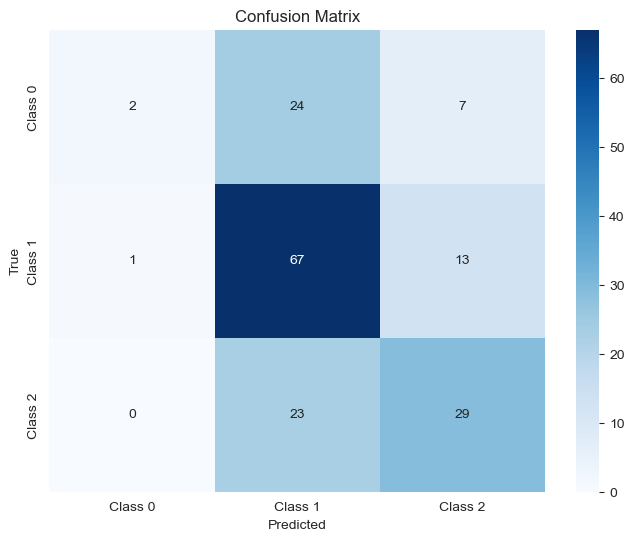

In [45]:
# Plot confusion matrix using seaborn heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Class 0', 'Class 1', 'Class 2'],
            yticklabels=['Class 0', 'Class 1', 'Class 2'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [52]:
# Calculate precision, recall, and f1 score
precision = precision_score(y_true_classes, y_pred_classes, average='weighted')
recall = recall_score(y_true_classes, y_pred_classes, average='weighted')
f1 = f1_score(y_true_classes, y_pred_classes, average='weighted')
accuracy = accuracy_score(y_true_classes, y_pred_classes)

In [60]:
# Create lists for labels and corresponding scores
labels = ['Precision', 'Recall', 'F1 Score', 'accuracy']
scores = [precision, recall, f1, accuracy]

In [59]:
scores

[0.6047034539878094,
 0.5903614457831325,
 0.5372866943784278,
 0.5903614457831325]

In [56]:
accuracy

0.5903614457831325

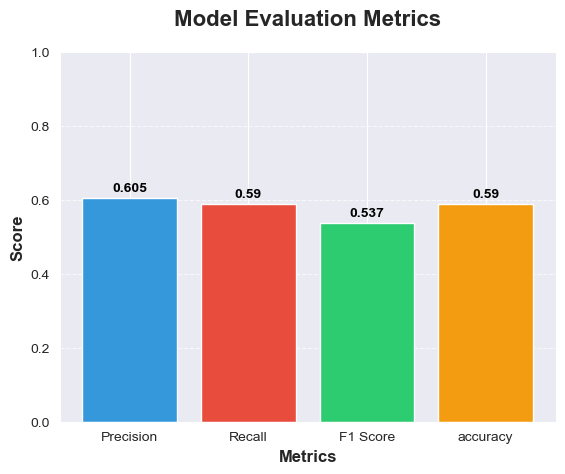

In [64]:
# Set a color palette for the bars (different colors)
colors = ['#3498db', '#e74c3c', '#2ecc71', '#f39c12']

# Plotting the bar chart 
fig, ax = plt.subplots()
bars = ax.bar(labels, scores, color=colors)

# Adding data values above the bars with adjusted positioning
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval + 0.01, round(yval, 3), ha='center', va='bottom', color='black', fontweight='bold')

# Adding title and labels
plt.title('Model Evaluation Metrics', fontsize=16, fontweight='bold', y=1.05)  # Adjusted y position for title
plt.xlabel('Metrics', fontsize=12, fontweight='bold')
plt.ylabel('Score', fontsize=12, fontweight='bold')

# Adjusting y-axis limits and grid
plt.ylim(0, 1)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Display the plot with x-axis labels
plt.xticks(labels)

# Show the plot
plt.show()
